# Simulations

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import anndata
import numpy as np
import pandas as pd
import seaborn as sb
import scipy.stats as stats
import matplotlib.pyplot as plt
from tabulate import tabulate
import os,sys,inspect
# setting the path to source
# sys.path.insert(0,os.path.dirname(os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))) + '/source') 
sys.path.append('../source') 

# new source imports 
import OrgAlign as orgalign
import Main
import MyFunctions 
import TimeSeriesPreprocessor
# import PathwayAnalyser

import warnings
warnings.filterwarnings("ignore")

### Simulate reference and query data 

**Input to Genes2Genes:** a reference adata object and a query adata object, each containing the pseudotime values in their obs variable named 'time'. 

In [36]:
q_cells= np.array([])
q_cells

array([], dtype=float64)

In [37]:
## Load dataset
adata = anndata.read_h5ad('/nfs/team205/ds40/OrgAlign/TutorialData/adata_pam_local.h5ad') # PAM

## Split in query and reference 
# (sampling along pseudotime bins)
np.random.seed(84894)
adata.obs['time_bins'] = pd.cut(adata.obs['time'], 10)
q_cells= np.array([])
for b in adata.obs['time_bins'].unique():
    n_cells = sum(adata.obs['time_bins'] == b)
    if n_cells >= 3:
        q_cells_bin = np.random.choice(adata.obs_names[adata.obs['time_bins'] == b], size=3, replace=False)
    else:
        q_cells_bin = np.random.choice(adata.obs_names[adata.obs['time_bins'] == b], size=n_cells, replace=False)
    q_cells = np.hstack([q_cells, q_cells_bin])

In [38]:
adata_query = adata[q_cells].copy()
adata_ref = adata[~adata.obs_names.isin(q_cells)].copy()

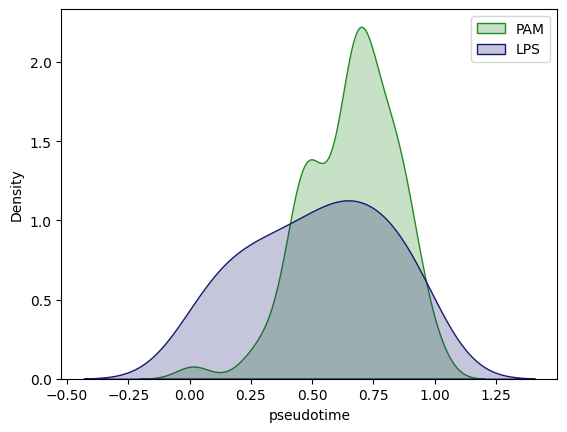

In [39]:
# Examine ref and query pseudotime distributions
sb.kdeplot(adata_ref.obs['time'], fill=True, label='PAM', color='forestgreen') 
sb.kdeplot(adata_query.obs['time'], fill=True, label='LPS', color='midnightblue'); plt.xlabel('pseudotime'); plt.legend()
plt.show()

### 1. Align a single gene of reference and query

Genes2Genes can find you an optimal alignment between the reference and query gene trajectories by matching or mismatching their respective time points based on corresponding levels of gene expression. It first interpolates the data to smoothen the trajectories. 
Example: align gene **NFKBIZ**

In [40]:
gene_list = adata_ref.var_names 

# Create a reference query aligner object
# Pass the reference adata, query adata, and the gene list to perform pairwise alignment
aligner = Main.RefQueryAligner(adata_ref, adata_query, gene_list, 40)
aligner.WEIGHT_BY_CELL_DENSITY = True

gene = 'NFKBIZ' # example gene for local dataset
#gene = 'TLR2'
# Run pairwise alignment between ref and query for the given gene
#al_obj = aligner.align_single_pair(gene, state_params=[0.95,0.4,0.4])
al_obj = aligner.align_single_pair(gene)


0123456789012345678901234567890123456789012345678901 Alignment index 
            0123456789012345678901234567890123456789 Reference index
------------****************************************
************-----------**************************^^^
012345678901           23456789012345678901234567777 Query index
IIIIIIIIIIIIDDDDDDDDDDDMMMMMMMMMMMMMMMMMMMMMMMMMMWWW 5-state string 


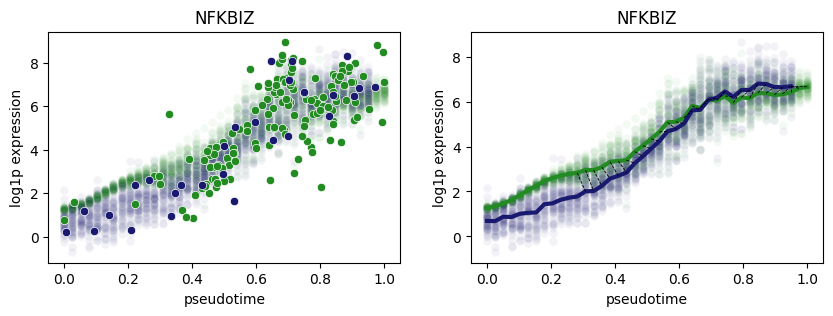

In [41]:
plt.subplots(1,2,figsize=(10,3))
plt.subplot(1,2,1)
al_obj.plotTimeSeries(aligner, plot_cells=True)
plt.subplot(1,2,2)
al_obj.plotTimeSeriesAlignment()
print(al_obj.al_visual)

## Test on pancreas dataset

In [56]:
pip install git+https://github.com/theislab/cellrank

  Cloning https://github.com/theislab/cellrank to /tmp/pip-req-build-dqp__1j1
  Running command git clone --filter=blob:none --quiet https://github.com/theislab/cellrank /tmp/pip-req-build-dqp__1j1
  Resolved https://github.com/theislab/cellrank to commit 44b213e8eae72e61df2b88cbdaafd3cb1482134a
  Running command git submodule update --init --recursive -q
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for cellrank: filename=cellrank-1.5.2.dev139+g44b213e-py3-none-any.whl size=237944 sha256=44406153bf9af7c12e4193e297aa741bee2c1825dee2abacf62a104d2ea5955f
  Stored in directory: /tmp/pip-ephem-wheel-cache-4ncdf3os/wheels/f6/f0/15/0406f4bc9f94841b8a48ce8aefc159b09d458484a455867664
Successfully built cellrank
  Attempting uninstall: cellrank
    Found existing installation: cellrank 1.5.1
    Uninstalling cellrank-1.5.1:
      Successfully uninstalled cellrank-1.5.1
Note: you may need to 

In [3]:
import scanpy as sc
from cellrank.datasets import pancreas_preprocessed

In [268]:
adata = pancreas_preprocessed()
adata.obs['time'] = adata.obs['dpt_pseudotime'].copy()
adata.X = adata.X.toarray()

In [269]:
# keep only differentiation 2 beta lineage
adata = adata[adata.obs['clusters'].isin(['Ngn3 low EP', 'Ngn3 high EP', 'Fev+', 'Beta'])].copy()

In [270]:
adata

AnnData object with n_obs × n_vars = 1845 × 2000
    obs: 'day', 'proliferation', 'G2M_score', 'S_score', 'phase', 'clusters_coarse', 'clusters', 'clusters_fine', 'louvain_Alpha', 'louvain_Beta', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'velocity_self_transition', 'dpt_pseudotime', 'time'
    var: 'highly_variable_genes', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'fit_r2', 'fit_alpha', 'fit_beta', 'fit_gamma', 'fit_t_', 'fit_scaling', 'fit_std_u', 'fit_std_s', 'fit_likelihood', 'fit_u0', 'fit_s0', 'fit_pval_steady', 'fit_steady_u', 'fit_steady_s', 'fit_variance', 'fit_alignment_scaling', 'velocity_genes'
    uns: 'clusters_colors', 'clusters_fine_colors', 'diffmap_evals', 'iroot', 'louvain_Alpha_colors', 'louvain_Beta_colors', 'neighbors', 'pca', 'recover_dynamics', 'velocity_graph', 'velocity_graph_neg', 'velocity_params'
    obsm: 'X_diffmap', 'X_pca', 'X_umap', 'velocity_umap'
    varm: 'PCs', 'loss'
    layers: 'Ms', 'Mu', '

/home/jovyan/my-conda-envs/genes2genes-env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


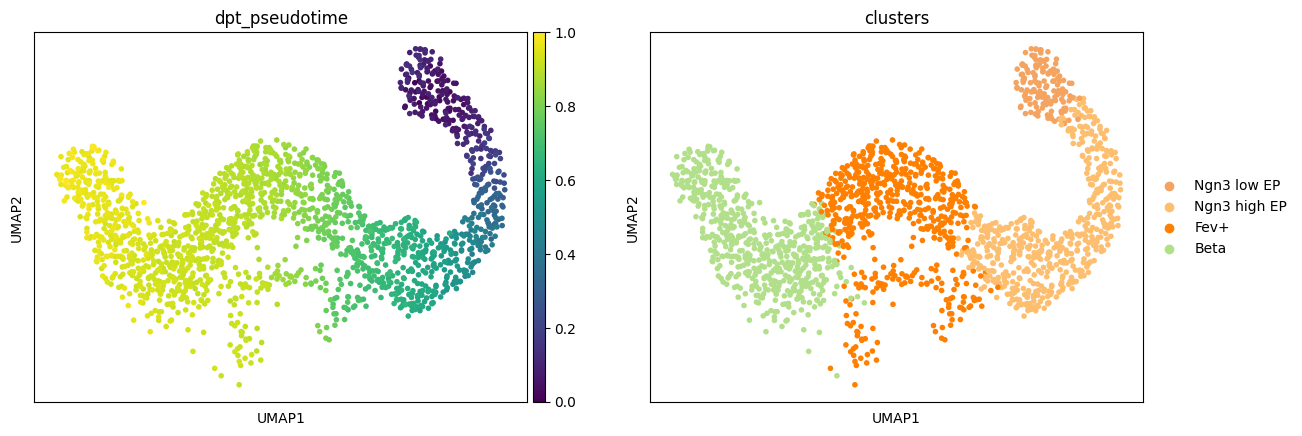

In [271]:
sc.pl.umap(adata, color=['dpt_pseudotime', 'clusters'])

### Simulating mismatch

1. Take out one region: change the size of mismatch and check overlap
2. Increase gene expression in a region 

In [272]:
def simulate_alignment2(adata, true_align_string, 
                       frac_query = 0.5,
                       seed=42352,
                       gene = 'Msi1',
                       n_stds = 1):
    np.random.seed(seed)
    n_bins=len(true_align_string)
    adata.obs['time_bins'] = pd.cut(adata.obs['time'], n_bins).astype('category').cat.codes
    q_cells= np.array([])

    ## Split in ref and query
    for i,b in enumerate(true_align_string):
        n_cells = sum(adata.obs['time_bins'] == i)
        q_cells_bin = np.random.choice(adata.obs_names[adata.obs['time_bins'] == i], size=int(np.round(n_cells*frac_query)), replace=False)
        q_cells = np.hstack([q_cells, q_cells_bin])

    adata_query = adata[q_cells].copy()
    adata_ref = adata[~adata.obs_names.isin(q_cells)].copy()

    for i,b in enumerate(true_align_string):
        bcells = adata_query.obs_names[adata_query.obs['time_bins'] == i]
        if b == 'D': ## delete cells
            adata_query = adata_query[~adata_query.obs_names.isin(bcells)].copy()
        if b == 'I': # change values for gene            
            X_query = adata_query.X.copy()
            X_gene = X_query[adata_query.obs_names.isin(bcells),adata_query.var_names == gene]
            X_query[adata_query.obs_names.isin(bcells),adata_query.var_names == gene] = X_gene + n_stds*X_gene.std() 
            adata_query.X = X_query.copy()
    return(adata_ref, adata_query)

In [281]:
def make_align_string(mm_type, mm_start = 10, n_bins = 40, mm_size=10):
    mm_ixs = range(mm_start, mm_start+mm_size)
    true_align_string = ''.join([mm_type if i in mm_ixs else 'M' for i in range(n_bins)])
    return(true_align_string)

def alignment_viz(aligner, al_obj):
#     plt.subplots(1,2,figsize=(10,3))
#     plt.subplot(1,2,1)
#     al_obj.plotTimeSeries(aligner, plot_cells=True)
#     plt.subplot(1,2,2)
#     al_obj.plotTimeSeriesAlignment()
    print(al_obj.al_visual)
    
def predict_alignment(adata_ref, adata_query, gene, n_bins=40):
    gene_list = adata_ref.var_names 
    aligner = Main.RefQueryAligner(adata_ref, adata_query, gene_list, n_bins)
    aligner.WEIGHT_BY_CELL_DENSITY = True
    al_obj = aligner.align_single_pair(gene)
    alignment_viz(aligner, al_obj)
    return(al_obj)

def get_ref_aling_str(al_obj):
    ref_ixs = (al_obj.al_visual.split('\n')[1]).split(' Reference')[0]
    al_str = al_obj.alignment_str

    ref_aling_str = ''.join([al_str[i] for i,p in enumerate(ref_ixs) if p!=' '])

    # collapse Vs
    ref_aling_str_collapsed = ''
    for i,p in enumerate(ref_aling_str):
        if p == 'V':
            if ref_aling_str[i-1]!='V':
                ref_aling_str_collapsed += 'M'
            else:
                ref_aling_str_collapsed += ''
        else:
            ref_aling_str_collapsed += p
    return(ref_aling_str_collapsed)

In [282]:
def run_match_accuracy(gene, align_params):
    match_dict = {'D':'mismatch', 'I':'mismatch', 'M':'match', 'V':'match', 'W':'match'}
    true_align_string = make_align_string(**align_params)
    rdata, qdata = simulate_alignment2(adata, true_align_string, gene=gene)
    al_obj = predict_alignment(rdata, qdata, gene=gene)

    true_ref_align_str = get_ref_aling_str(al_obj)

    # get mismatch accuracy
    outcome_df = pd.DataFrame([(i, match_dict[true_align_string[i]], match_dict[c]) for i,c in enumerate(get_ref_aling_str(al_obj) )],
                 columns=['position', 'true', 'predicted']
                )
    outcome_df['correct'] = outcome_df['true'] == outcome_df['predicted']
    accuracy = outcome_df['correct'].sum()/outcome_df['correct'].shape[0]
    outcome_df['accuracy'] = accuracy
    outcome_df['gene'] = gene
    for p in align_params.keys():
        outcome_df[p] = align_params[p]
    outcome_df = outcome_df[list(align_params.keys()) + ['gene', 'accuracy']].drop_duplicates()
    return(outcome_df)

# gene = 'Rgs17'
# match_outcome = pd.DataFrame()
# for st in range(0,35,5):
#     for s in [3, 5, 10, 15, 20]:
#         align_params={'mm_type':'D', 'n_bins':40, 'mm_start':st, 'mm_size':s}
#         match_outcome = pd.concat([match_outcome, run_match_accuracy(gene, align_params)])


Select genes w interesting trends (from CellRank paper)

In [283]:
genes = ['Rgs17', 'Sox9', 'Ins1', "Dcx", 'Map2']
match_outcome = pd.DataFrame()
for g in genes:
# for st in range(0,35,5):
#     for s in [3, 5, 10, 15, 20]:
    align_params={'mm_type':'D', 'n_bins':40, 'mm_start':0, 'mm_size':1}
    match_outcome = pd.concat([match_outcome, run_match_accuracy(g, align_params)])

012345678901234567890123456789012345678 Alignment index 
012345678901234567890123456789012345678 Reference index
***************************************
***************************************
012345678901234567890123456789012345678 Query index
MMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMM 5-state string 
012345678901234567890123456789012345678 Alignment index 
012345678901234567890123456789012345678 Reference index
***************************************
***************************************
012345678901234567890123456789012345678 Query index
MMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMM 5-state string 
012345678901234567890123456789012345678 Alignment index 
012345678901234567890123456789012345678 Reference index
***************************************
***************************************
012345678901234567890123456789012345678 Query index
MMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMM 5-state string 
012345678901234567890123456789012345678 Alignment index 
012345678901234567890123456789012345678 

In [284]:
match_outcome = pd.DataFrame()
for g in genes:
    for st in range(0,35,5):
        for s in [1, 3, 5, 10, 15, 20]:
            align_params={'mm_type':'D', 'n_bins':40, 'mm_start':st, 'mm_size':s}
            match_outcome = pd.concat([match_outcome, run_match_accuracy(g, align_params)])

012345678901234567890123456789012345678 Alignment index 
012345678901234567890123456789012345678 Reference index
***************************************
***************************************
012345678901234567890123456789012345678 Query index
MMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMM 5-state string 
012345678901234567890123456789012345678 Alignment index 
012345678901234567890123456789012345678 Reference index
***************************************
-**************************************
 01234567890123456789012345678901234567 Query index
DMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMM 5-state string 
0123456789012345678901234567890123456789 Alignment index 
 012345678901234567890123456789012345678 Reference index
-***************************************
*-----**********************************
0     1234567890123456789012345678901234 Query index
IDDDDDMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMM 5-state string 
0123456789012345678901234567890123456789 Alignment index 
 01234567890123456789012345678901

(0.0, 1.0)

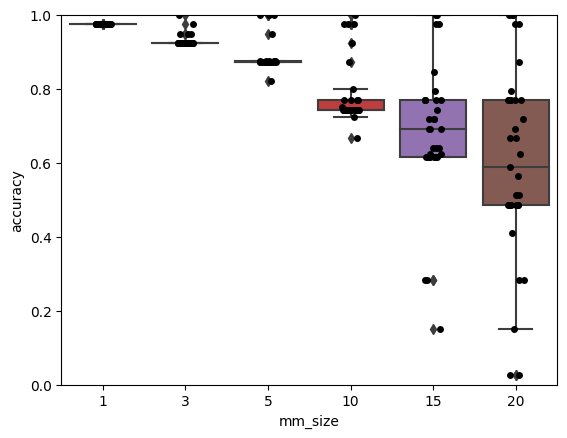

In [285]:
import seaborn as sns
sns.boxplot(data=match_outcome, x='mm_size', y='accuracy');
sns.stripplot(data=match_outcome, x='mm_size', y='accuracy', color='black');
plt.ylim(0,1)

(0.0, 1.0)

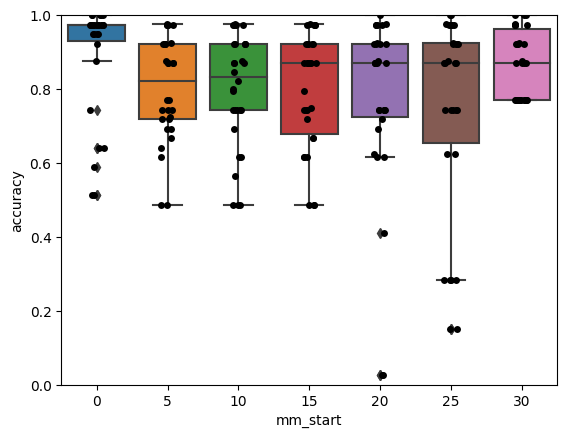

In [286]:
import seaborn as sns
sns.boxplot(data=match_outcome, x='mm_start', y='accuracy');
sns.stripplot(data=match_outcome, x='mm_start', y='accuracy', color='black');
plt.ylim(0,1)

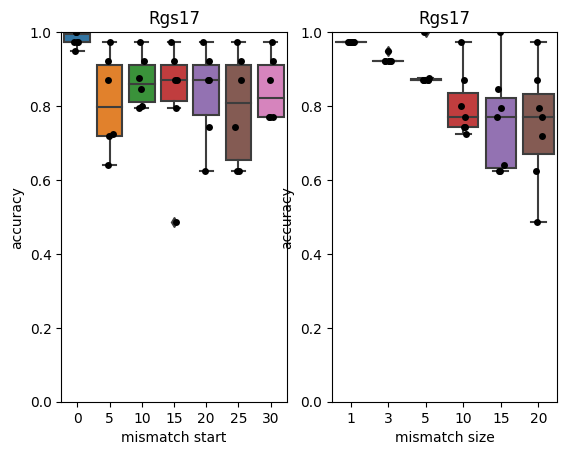

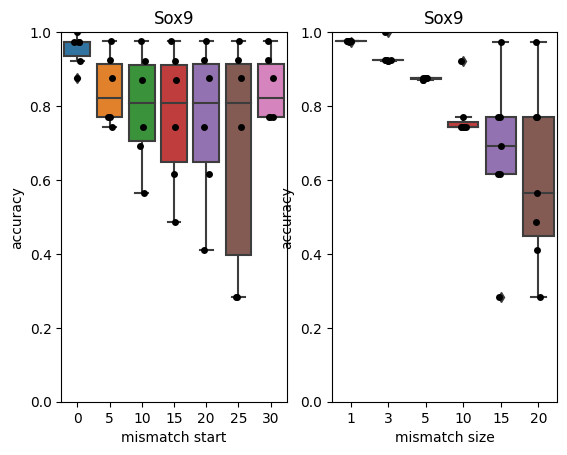

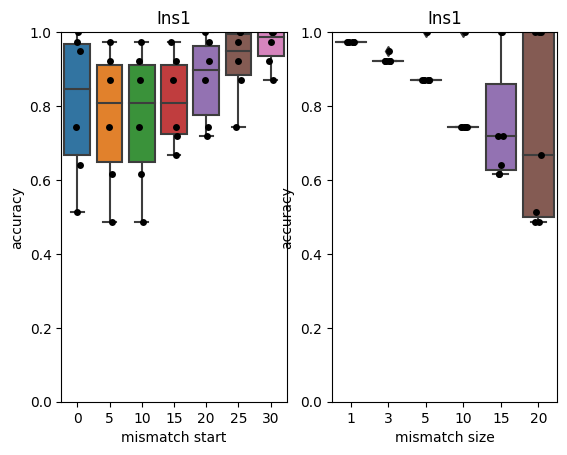

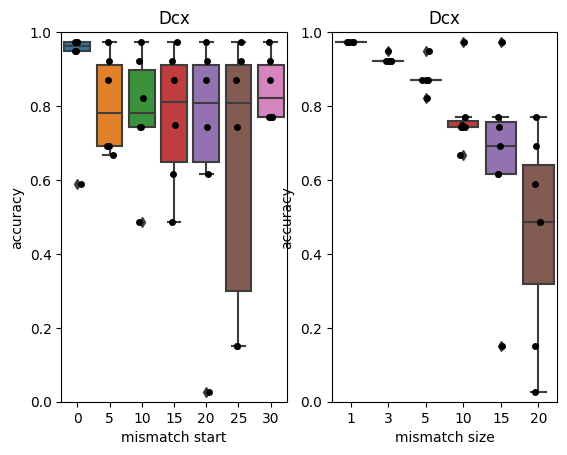

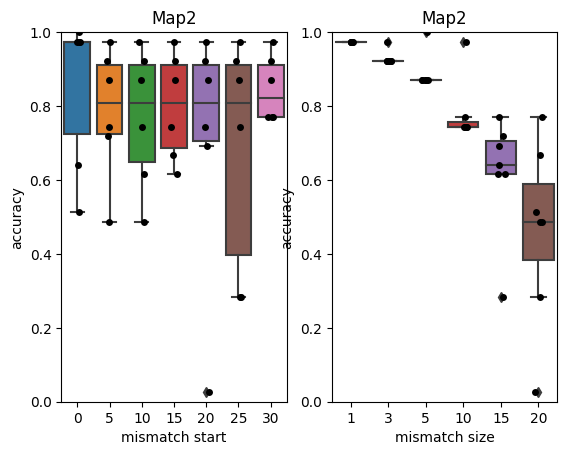

In [289]:
for i,g in enumerate(genes):
    plt.subplot(121);
    sns.boxplot(data=match_outcome[match_outcome.gene == g], x='mm_start', y='accuracy');
    sns.stripplot(data=match_outcome[match_outcome.gene == g], x='mm_start', y='accuracy', color='black');
    plt.ylim(0,1);
    plt.xlabel('mismatch start');
    plt.title(g);
    plt.subplot(122);
    sns.boxplot(data=match_outcome[match_outcome.gene == g], x='mm_size', y='accuracy');
    sns.stripplot(data=match_outcome[match_outcome.gene == g], x='mm_size', y='accuracy', color='black');
    plt.ylim(0,1);
    plt.xlabel('mismatch size');
    plt.title(g);
    plt.show()

In [290]:
match_outcome.to_csv('./data/match_accuracy_pancreas.csv')

### Simulating warps

Duplicate regions of pseudotshape in the query. 

In [ ]:
## to do

### Shift score
Taking area under the curve for the match matrix.
Look into `plot_comprehensive_alignment_landscape_plot`

`compute_alignment_area_diff_distance` (giving as A2 a perfect match case - diagonal of the matrix)

In [ ]:
## to do